# Кластерный анализ экономических данных городов

## Цель работы
Выполнить три типа кластерного анализа:
1. Иерархический кластерный анализ
2. Кластерный анализ методом k-means
3. Кластерный анализ методом DBSCAN

Определить оптимальное число кластеров для каждого метода и дать интерпретацию результатов.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings

warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Загрузка и подготовка данных


In [34]:
# Загрузка данных (разделитель ;, десятичный разделитель ,)
df = pd.read_csv('Econom_Cities_data.csv', sep=';', decimal=',')

print(df.shape)
df.head()

(48, 4)


,City,Work,Price,Salary
0,Amsterdam,1714,65.6,49.0
1,Athens,1792,53.8,30.4
2,Bogota,2152,37.9,11.5
3,Bombay,2052,30.3,5.3
4,Brussels,1708,73.8,50.5


In [37]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    48 non-null     object 
 1   Work    48 non-null     int64  
 2   Price   48 non-null     float64
 3   Salary  48 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6+ KB


,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


In [38]:
# Обработка пропущенных значений
print(df.isnull().sum())

# Замена -9999 на NaN
df_clean = df.copy()
df_clean = df_clean.replace(-9999, np.nan)


# Проверка строк с пропусками
missing_rows = df_clean[df_clean.isnull().any(axis=1)]
print(len(missing_rows))
print(missing_rows[['City', 'Work', 'Price', 'Salary']])


City      0
Work      0
Price     0
Salary    0
dtype: int64
2
       City  Work  Price  Salary
6     Cairo   NaN   37.1     NaN
17  Jakarta   NaN   43.6     NaN


In [ ]:
# Удаление строк с пропусками 
df_final = df_clean.dropna().reset_index(drop=True)

# Сохранение названий городов для интерпретации
city_names = df_final['City'].values

# Выделение признаков для кластеризации
features = df_final[['Work', 'Price', 'Salary']].copy()
print(f"\nПризнаки для кластеризации:\n{features.head()}")


Размер данных после удаления пропусков: (46, 4)
Удалено строк: 2

Признаки для кластеризации:
     Work  Price  Salary
0  1714.0   65.6    49.0
1  1792.0   53.8    30.4
2  2152.0   37.9    11.5
3  2052.0   30.3     5.3
4  1708.0   73.8    50.5


In [ ]:
# Стандартизация данных
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

print(features_scaled_df.head())
print(f"Среднее: {features_scaled_df.mean().values}")
print(f"Стандартное отклонение: {features_scaled_df.std().values}")


       Work     Price    Salary
0 -0.962166 -0.212712  0.386095
1 -0.509827 -0.770489 -0.373488
2  1.577891 -1.522069 -1.145323
3  0.997969 -1.881316 -1.398517
4 -0.996961  0.174896  0.447351
Среднее: {features_scaled_df.mean().values}
Стандартное отклонение: [1.01105006 1.01105006 1.01105006]


## 2. Исследовательский анализ данных (EDA)


In [7]:
# Описательная статистика по исходным признакам
print("Описательная статистика по признакам:")
print(features.describe())


Описательная статистика по признакам:
              Work       Price      Salary
count    46.000000   46.000000   46.000000
mean   1879.913043   70.100000   39.545652
std     174.342552   21.389177   24.757703
min    1583.000000   30.300000    2.700000
25%    1745.250000   51.775000   14.375000
50%    1849.000000   70.950000   43.650000
75%    1976.250000   81.900000   59.700000
max    2375.000000  115.500000  100.000000


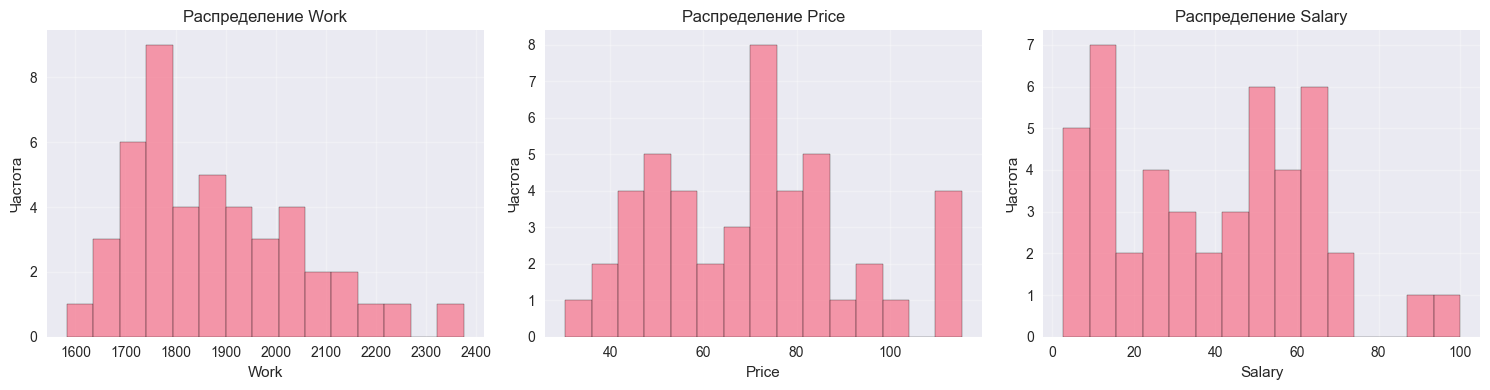

In [8]:
# Визуализация распределений признаков
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(features.columns):
    axes[idx].hist(features[col], bins=15, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


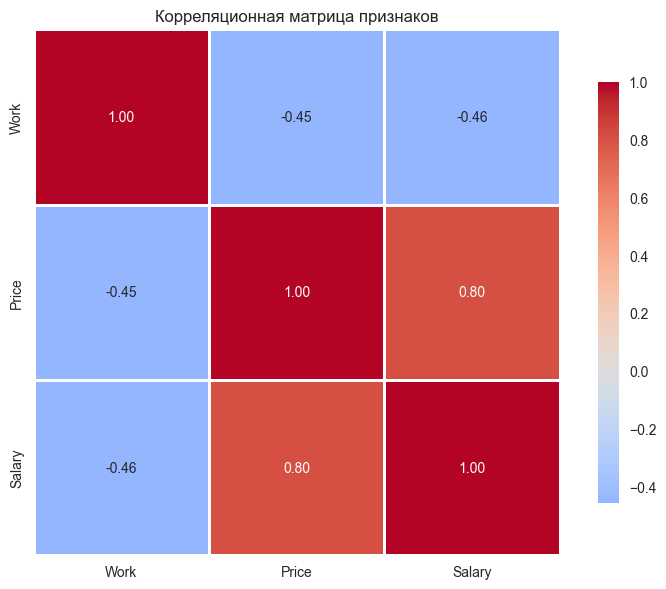

Корреляционная матрица:
            Work     Price    Salary
Work    1.000000 -0.452176 -0.457187
Price  -0.452176  1.000000  0.803825
Salary -0.457187  0.803825  1.000000


In [9]:
# Корреляционная матрица
corr_matrix = features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

print("Корреляционная матрица:")
print(corr_matrix)


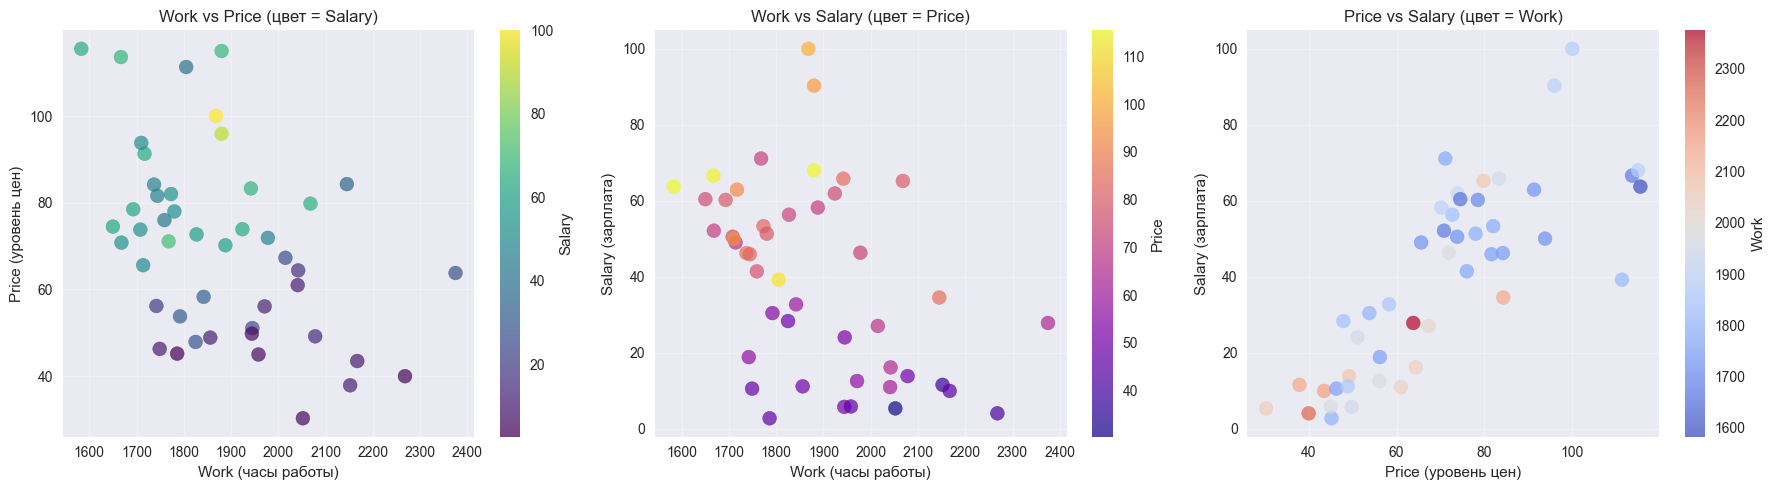

In [10]:
# Предварительная визуализация данных (2D проекции)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Work vs Price
scatter1 = axes[0].scatter(features['Work'], features['Price'], 
                           c=features['Salary'], cmap='viridis', s=100, alpha=0.7)
axes[0].set_xlabel('Work (часы работы)')
axes[0].set_ylabel('Price (уровень цен)')
axes[0].set_title('Work vs Price (цвет = Salary)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Salary')

# Work vs Salary
scatter2 = axes[1].scatter(features['Work'], features['Salary'], 
                           c=features['Price'], cmap='plasma', s=100, alpha=0.7)
axes[1].set_xlabel('Work (часы работы)')
axes[1].set_ylabel('Salary (зарплата)')
axes[1].set_title('Work vs Salary (цвет = Price)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Price')

# Price vs Salary
scatter3 = axes[2].scatter(features['Price'], features['Salary'], 
                           c=features['Work'], cmap='coolwarm', s=100, alpha=0.7)
axes[2].set_xlabel('Price (уровень цен)')
axes[2].set_ylabel('Salary (зарплата)')
axes[2].set_title('Price vs Salary (цвет = Work)')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Work')

plt.tight_layout()
plt.show()


## 3. Иерархический кластерный анализ


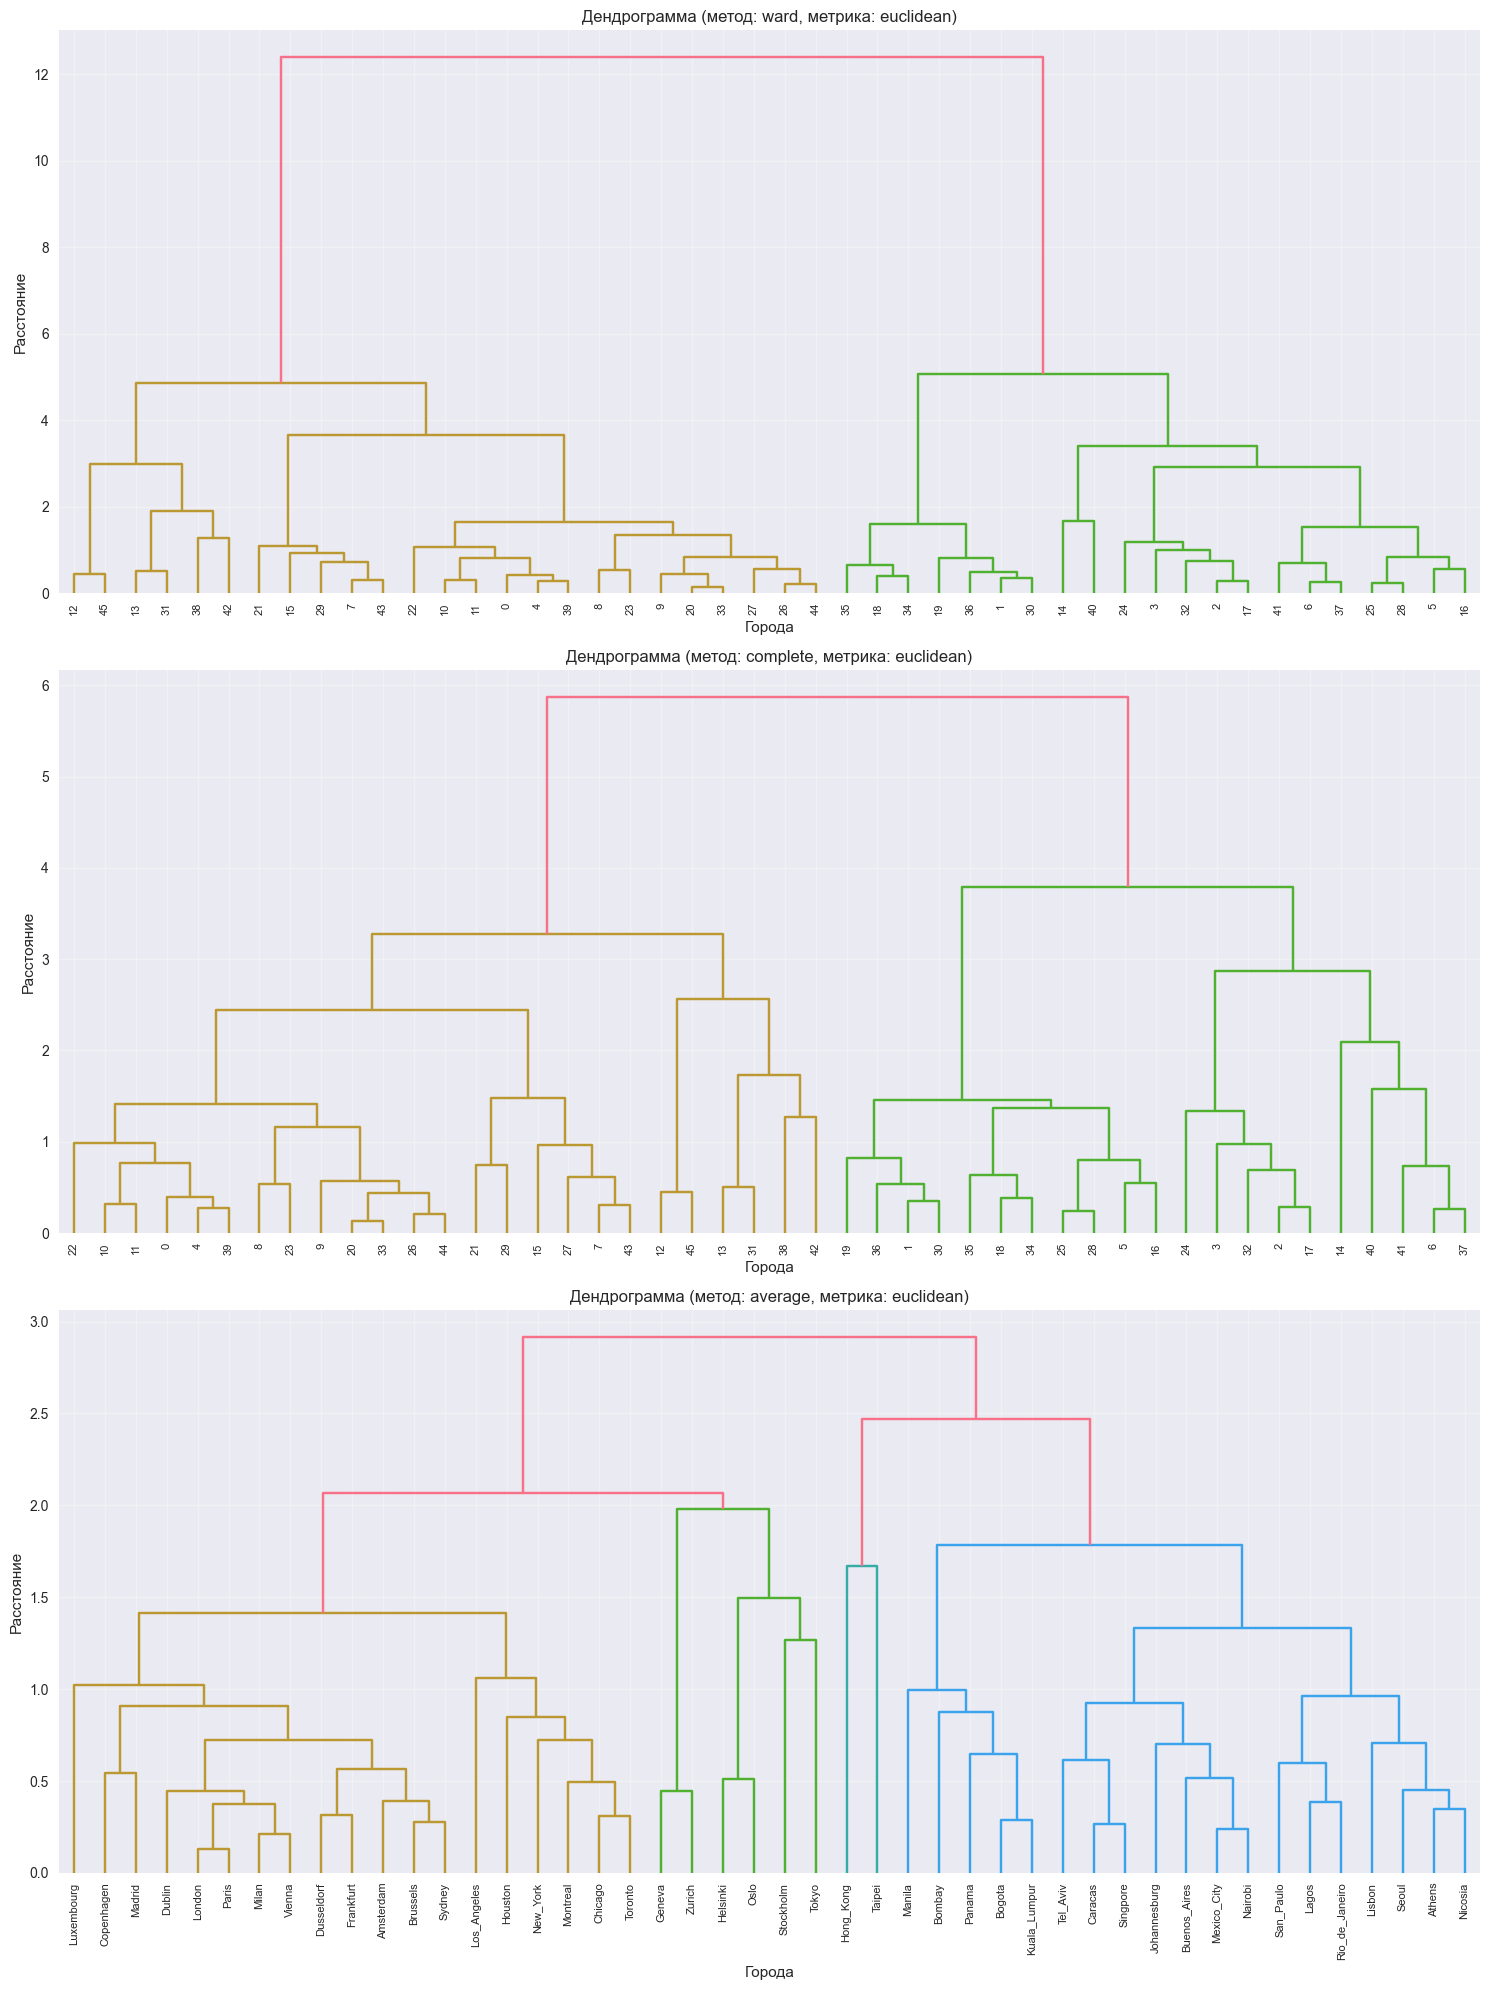

In [11]:
# Тестирование различных методов связывания и метрик расстояния
methods = ['ward', 'complete', 'average']
metrics = ['euclidean']  # ward работает только с euclidean

fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for idx, method in enumerate(methods):
    # Построение связи
    if method == 'ward':
        Z = linkage(features_scaled, method=method, metric='euclidean')
    else:
        Z = linkage(features_scaled, method=method, metric='euclidean')
    
    # Построение дендрограммы
    dendrogram(Z, ax=axes[idx], leaf_rotation=90, leaf_font_size=8,
               labels=city_names if idx == 2 else None)  # Показываем метки только на последнем графике
    axes[idx].set_title(f'Дендрограмма (метод: {method}, метрика: euclidean)')
    axes[idx].set_xlabel('Города')
    axes[idx].set_ylabel('Расстояние')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


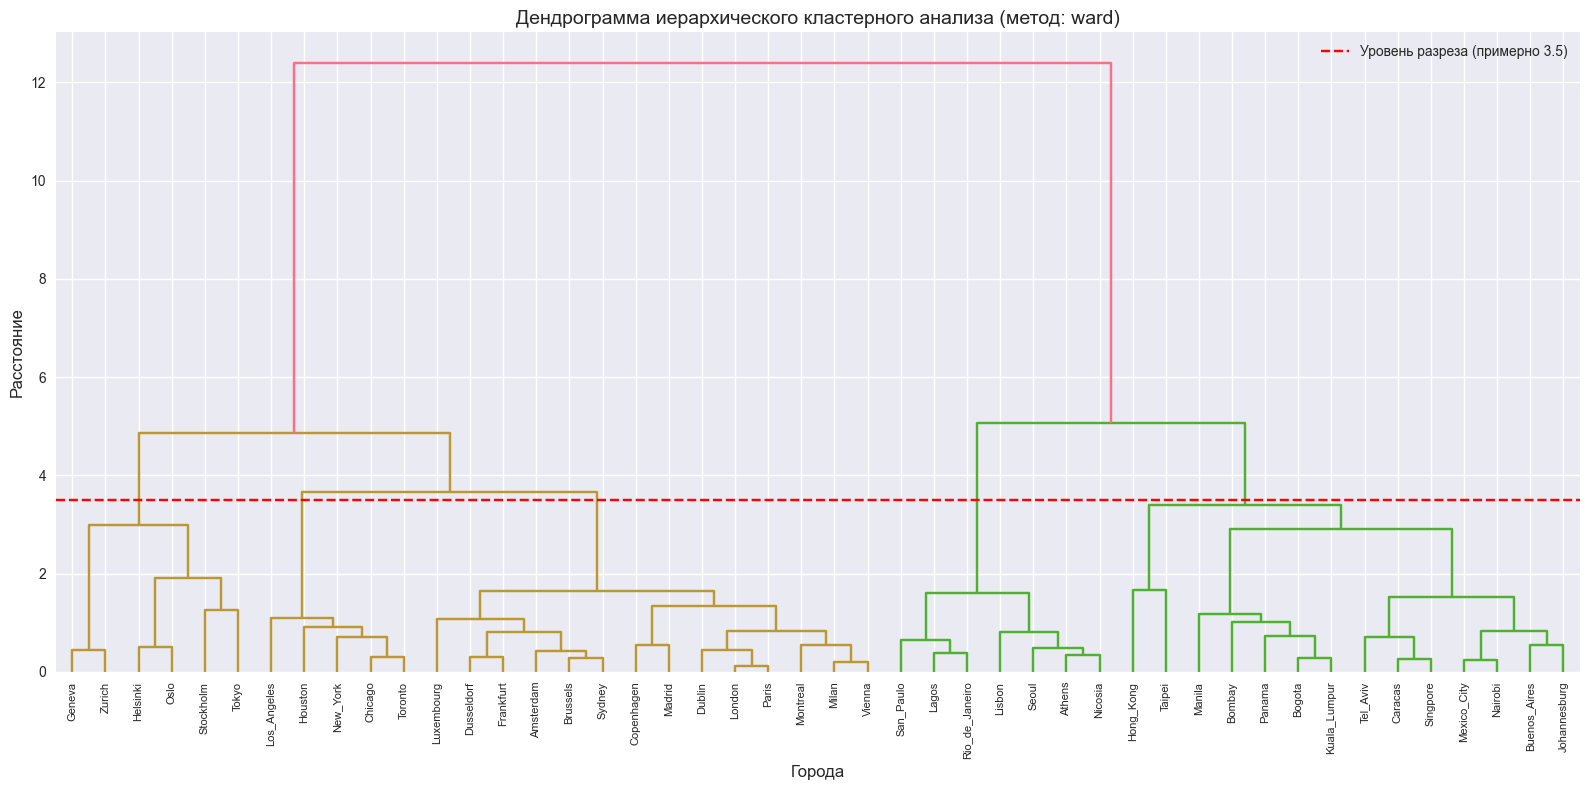

In [12]:
# Выбираем метод ward для дальнейшего анализа (обычно дает хорошие результаты)
method = 'ward'
Z = linkage(features_scaled, method=method, metric='euclidean')

# Построение детальной дендрограммы
plt.figure(figsize=(16, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=city_names)
plt.title('Дендрограмма иерархического кластерного анализа (метод: ward)', fontsize=14)
plt.xlabel('Города', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.axhline(y=3.5, color='r', linestyle='--', label='Уровень разреза (примерно 3.5)')
plt.legend()
plt.tight_layout()
plt.show()


n_clusters = 2: Silhouette Score = 0.470
n_clusters = 3: Silhouette Score = 0.361
n_clusters = 4: Silhouette Score = 0.355
n_clusters = 5: Silhouette Score = 0.348
n_clusters = 6: Silhouette Score = 0.366
n_clusters = 7: Silhouette Score = 0.396
n_clusters = 8: Silhouette Score = 0.399
n_clusters = 9: Silhouette Score = 0.410
n_clusters = 10: Silhouette Score = 0.394


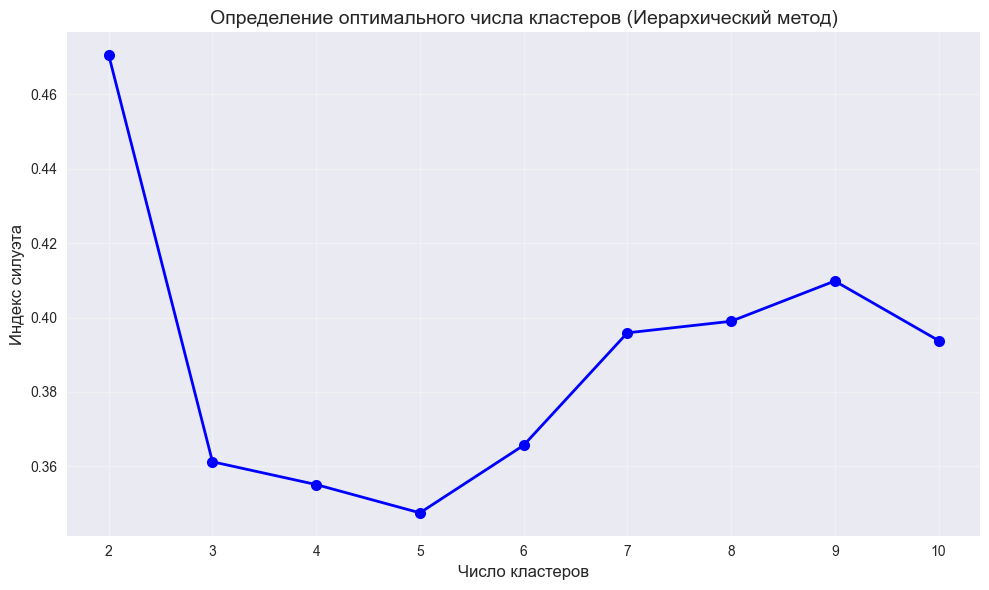


Оптимальное число кластеров (по индексу силуэта): 2


In [13]:
# Определение оптимального числа кластеров методом индекса силуэта
silhouette_scores = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(features_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}: Silhouette Score = {silhouette_avg:.3f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Индекс силуэта', fontsize=12)
plt.title('Определение оптимального числа кластеров (Иерархический метод)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(n_clusters_range)
plt.tight_layout()
plt.show()

# Выбор оптимального числа кластеров
optimal_n_hierarchical = n_clusters_range[np.argmax(silhouette_scores)]
print(f"\nОптимальное число кластеров (по индексу силуэта): {optimal_n_hierarchical}")


In [14]:
# Выполнение иерархической кластеризации с оптимальным числом кластеров
n_clusters_hierarchical = optimal_n_hierarchical  # Используем оптимальное значение

# Используем AgglomerativeClustering для получения меток
hierarchical_clustering = AgglomerativeClustering(
    n_clusters=n_clusters_hierarchical, 
    linkage='ward'
)
labels_hierarchical = hierarchical_clustering.fit_predict(features_scaled)

# Добавляем метки кластеров к исходным данным
df_hierarchical = df_final.copy()
df_hierarchical['Cluster'] = labels_hierarchical

print(f"Распределение городов по кластерам (Иерархический метод, n={n_clusters_hierarchical}):")
print(df_hierarchical['Cluster'].value_counts().sort_index())

print("\nГорода по кластерам:")
for cluster in sorted(df_hierarchical['Cluster'].unique()):
    cities_in_cluster = df_hierarchical[df_hierarchical['Cluster'] == cluster]['City'].values
    print(f"\nКластер {cluster} ({len(cities_in_cluster)} городов):")
    print(f"  {', '.join(cities_in_cluster)}")


Распределение городов по кластерам (Иерархический метод, n=2):
Cluster
0    21
1    25
Name: count, dtype: int64

Города по кластерам:

Кластер 0 (21 городов):
  Athens, Bogota, Bombay, Buenos_Aires, Caracas, Hong_Kong, Johannesburg, Kuala_Lumpur, Lagos, Lisbon, Manila, Mexico_City, Nairobi, Nicosia, Panama, Rio_de_Janeiro, San_Paulo, Seoul, Singpore, Taipei, Tel_Aviv

Кластер 1 (25 городов):
  Amsterdam, Brussels, Chicago, Copenhagen, Dublin, Dusseldorf, Frankfurt, Geneva, Helsinki, Houston, London, Los_Angeles, Luxembourg, Madrid, Milan, Montreal, New_York, Oslo, Paris, Stockholm, Sydney, Tokyo, Toronto, Vienna, Zurich


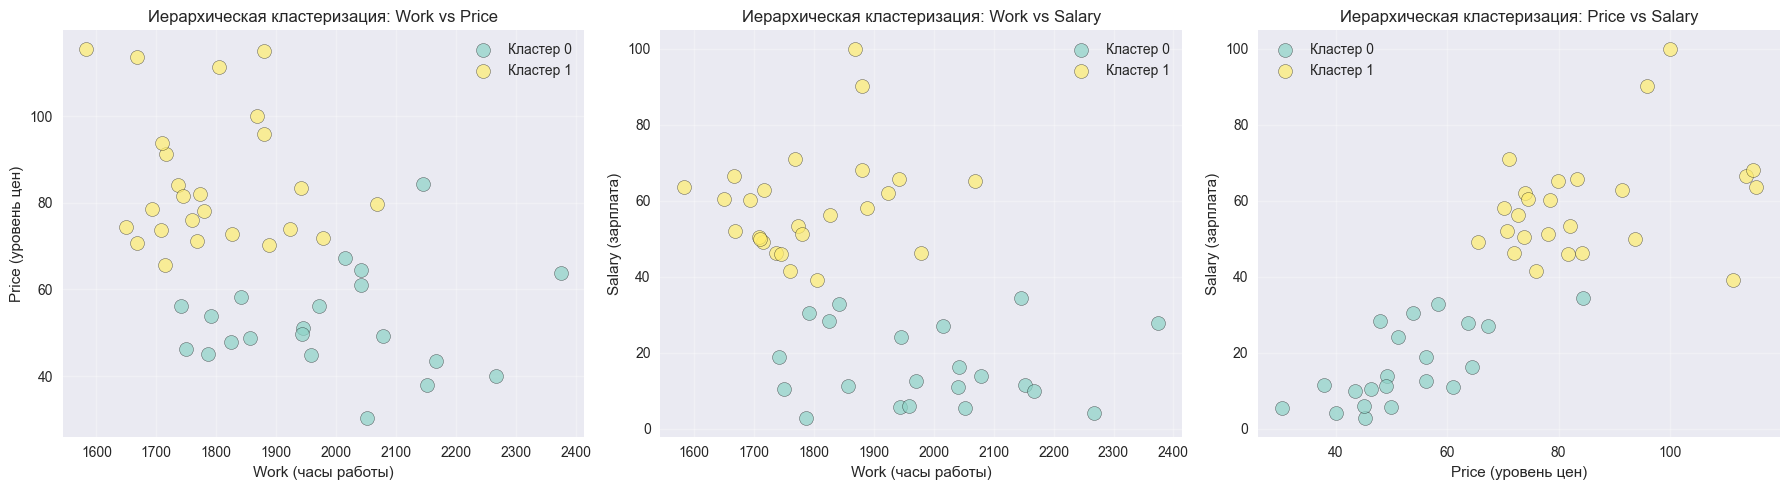

In [15]:
# Визуализация результатов иерархической кластеризации
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter_colors = plt.cm.Set3(np.linspace(0, 1, n_clusters_hierarchical))

# Work vs Price
for cluster in range(n_clusters_hierarchical):
    mask = labels_hierarchical == cluster
    axes[0].scatter(features['Work'][mask], features['Price'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
axes[0].set_xlabel('Work (часы работы)')
axes[0].set_ylabel('Price (уровень цен)')
axes[0].set_title('Иерархическая кластеризация: Work vs Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Work vs Salary
for cluster in range(n_clusters_hierarchical):
    mask = labels_hierarchical == cluster
    axes[1].scatter(features['Work'][mask], features['Salary'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
axes[1].set_xlabel('Work (часы работы)')
axes[1].set_ylabel('Salary (зарплата)')
axes[1].set_title('Иерархическая кластеризация: Work vs Salary')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Price vs Salary
for cluster in range(n_clusters_hierarchical):
    mask = labels_hierarchical == cluster
    axes[2].scatter(features['Price'][mask], features['Salary'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
axes[2].set_xlabel('Price (уровень цен)')
axes[2].set_ylabel('Salary (зарплата)')
axes[2].set_title('Иерархическая кластеризация: Price vs Salary')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Статистика по кластерам (иерархический метод)
print("Средние значения признаков по кластерам (Иерархический метод):")
cluster_stats_hierarchical = df_hierarchical.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
print(cluster_stats_hierarchical.round(2))

print("\nРазмеры кластеров:")
print(df_hierarchical.groupby('Cluster').size())


Средние значения признаков по кластерам (Иерархический метод):
            Work  Price  Salary
Cluster                        
0        1987.86  52.40   16.35
1        1789.24  84.97   59.03

Размеры кластеров:
Cluster
0    21
1    25
dtype: int64


## 4. Кластерный анализ методом K-means


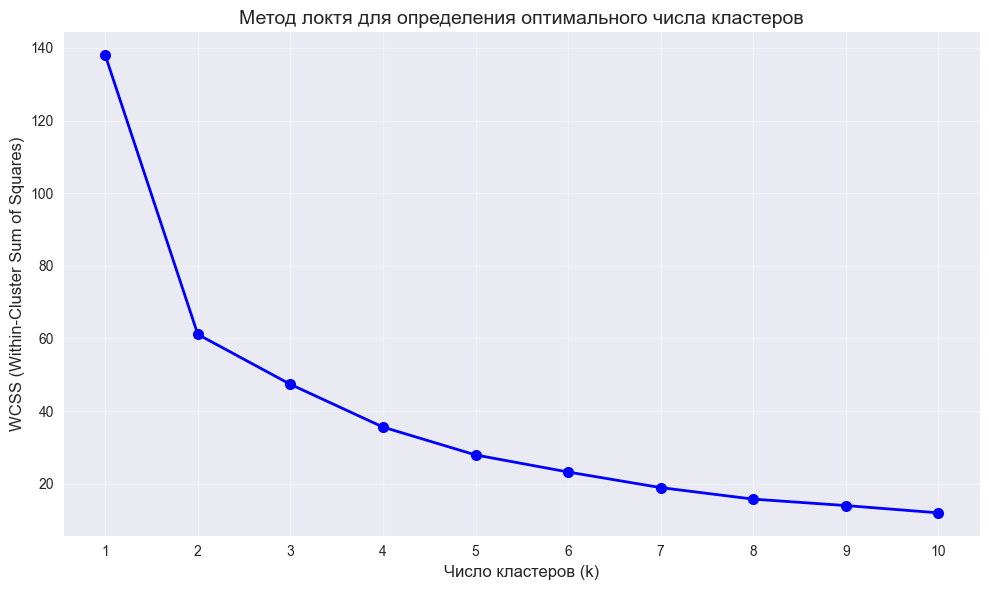

WCSS по числу кластеров:
k = 1: WCSS = 138.00
k = 2: WCSS = 61.12
k = 3: WCSS = 47.36
k = 4: WCSS = 35.59
k = 5: WCSS = 27.92
k = 6: WCSS = 23.21
k = 7: WCSS = 18.92
k = 8: WCSS = 15.75
k = 9: WCSS = 13.98
k = 10: WCSS = 11.97


In [17]:
# Метод локтя (Elbow method)
wcss = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Число кластеров (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Метод локтя для определения оптимального числа кластеров', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(n_clusters_range)
plt.tight_layout()
plt.show()

print("WCSS по числу кластеров:")
for n, w in zip(n_clusters_range, wcss):
    print(f"k = {n}: WCSS = {w:.2f}")


k = 2: Silhouette = 0.470, DB Index = 0.808
k = 3: Silhouette = 0.388, DB Index = 0.905
k = 4: Silhouette = 0.340, DB Index = 1.098
k = 5: Silhouette = 0.369, DB Index = 0.936
k = 6: Silhouette = 0.373, DB Index = 0.933
k = 7: Silhouette = 0.368, DB Index = 0.882
k = 8: Silhouette = 0.406, DB Index = 0.714
k = 9: Silhouette = 0.364, DB Index = 0.711
k = 10: Silhouette = 0.401, DB Index = 0.634


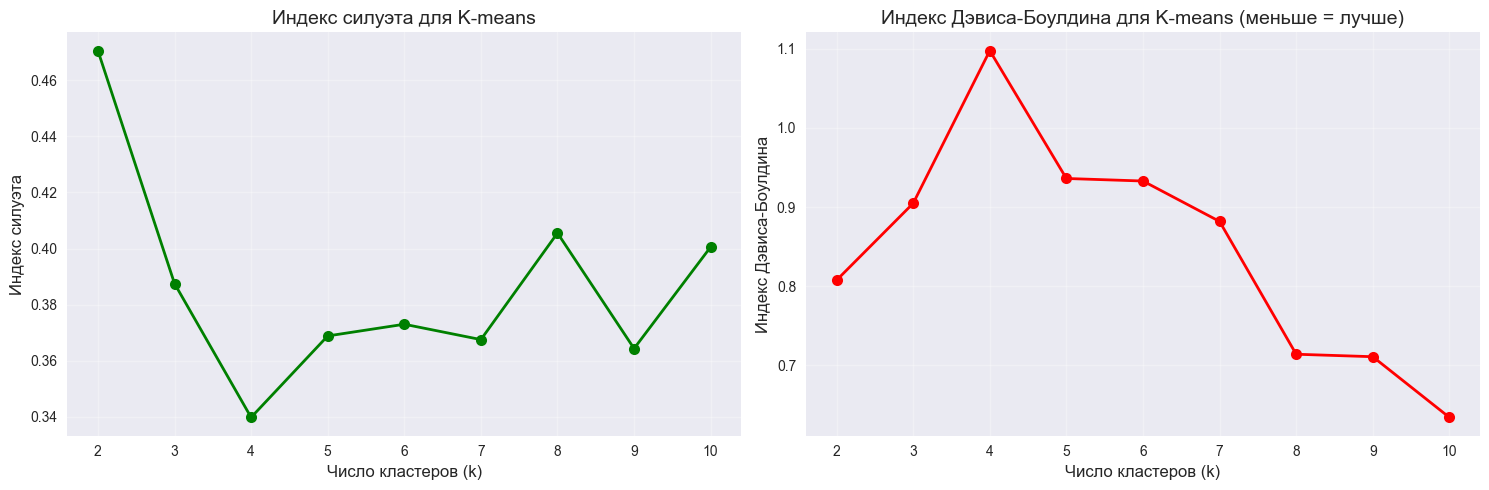


Оптимальное число кластеров (по индексу силуэта): 2
Оптимальное число кластеров (по индексу Дэвиса-Боулдина): 10

Выбранное число кластеров для K-means: 2


In [18]:
# Индекс силуэта для k-means
silhouette_scores_kmeans = []
db_scores_kmeans = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    
    silhouette_avg = silhouette_score(features_scaled, labels)
    db_score = davies_bouldin_score(features_scaled, labels)
    
    silhouette_scores_kmeans.append(silhouette_avg)
    db_scores_kmeans.append(db_score)
    
    print(f"k = {n_clusters}: Silhouette = {silhouette_avg:.3f}, DB Index = {db_score:.3f}")

# Визуализация метрик
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(n_clusters_range, silhouette_scores_kmeans, 'go-', linewidth=2, markersize=8)
ax1.set_xlabel('Число кластеров (k)', fontsize=12)
ax1.set_ylabel('Индекс силуэта', fontsize=12)
ax1.set_title('Индекс силуэта для K-means', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_clusters_range)

ax2.plot(n_clusters_range, db_scores_kmeans, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Число кластеров (k)', fontsize=12)
ax2.set_ylabel('Индекс Дэвиса-Боулдина', fontsize=12)
ax2.set_title('Индекс Дэвиса-Боулдина для K-means (меньше = лучше)', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(n_clusters_range)

plt.tight_layout()
plt.show()

# Определение оптимального числа кластеров
optimal_n_kmeans_sil = n_clusters_range[np.argmax(silhouette_scores_kmeans)]
optimal_n_kmeans_db = n_clusters_range[np.argmin(db_scores_kmeans)]

print(f"\nОптимальное число кластеров (по индексу силуэта): {optimal_n_kmeans_sil}")
print(f"Оптимальное число кластеров (по индексу Дэвиса-Боулдина): {optimal_n_kmeans_db}")

# Используем значение по индексу силуэта
optimal_n_kmeans = optimal_n_kmeans_sil
print(f"\nВыбранное число кластеров для K-means: {optimal_n_kmeans}")


In [19]:
# Выполнение K-means с оптимальным числом кластеров
n_clusters_kmeans = optimal_n_kmeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(features_scaled)

# Добавляем метки кластеров к исходным данным
df_kmeans = df_final.copy()
df_kmeans['Cluster'] = labels_kmeans

print(f"Распределение городов по кластерам (K-means, n={n_clusters_kmeans}):")
print(df_kmeans['Cluster'].value_counts().sort_index())

print("\nГорода по кластерам:")
for cluster in sorted(df_kmeans['Cluster'].unique()):
    cities_in_cluster = df_kmeans[df_kmeans['Cluster'] == cluster]['City'].values
    print(f"\nКластер {cluster} ({len(cities_in_cluster)} городов):")
    print(f"  {', '.join(cities_in_cluster)}")


Распределение городов по кластерам (K-means, n=2):
Cluster
0    21
1    25
Name: count, dtype: int64

Города по кластерам:

Кластер 0 (21 городов):
  Athens, Bogota, Bombay, Buenos_Aires, Caracas, Hong_Kong, Johannesburg, Kuala_Lumpur, Lagos, Lisbon, Manila, Mexico_City, Nairobi, Nicosia, Panama, Rio_de_Janeiro, San_Paulo, Seoul, Singpore, Taipei, Tel_Aviv

Кластер 1 (25 городов):
  Amsterdam, Brussels, Chicago, Copenhagen, Dublin, Dusseldorf, Frankfurt, Geneva, Helsinki, Houston, London, Los_Angeles, Luxembourg, Madrid, Milan, Montreal, New_York, Oslo, Paris, Stockholm, Sydney, Tokyo, Toronto, Vienna, Zurich


In [20]:
# Центры кластеров (в исходных масштабах)
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=features.columns)
centers_df.index.name = 'Cluster'
print("Центры кластеров K-means (в исходных масштабах):")
print(centers_df.round(2))


Центры кластеров K-means (в исходных масштабах):
            Work  Price  Salary
Cluster                        
0        1987.86  52.40   16.35
1        1789.24  84.97   59.03


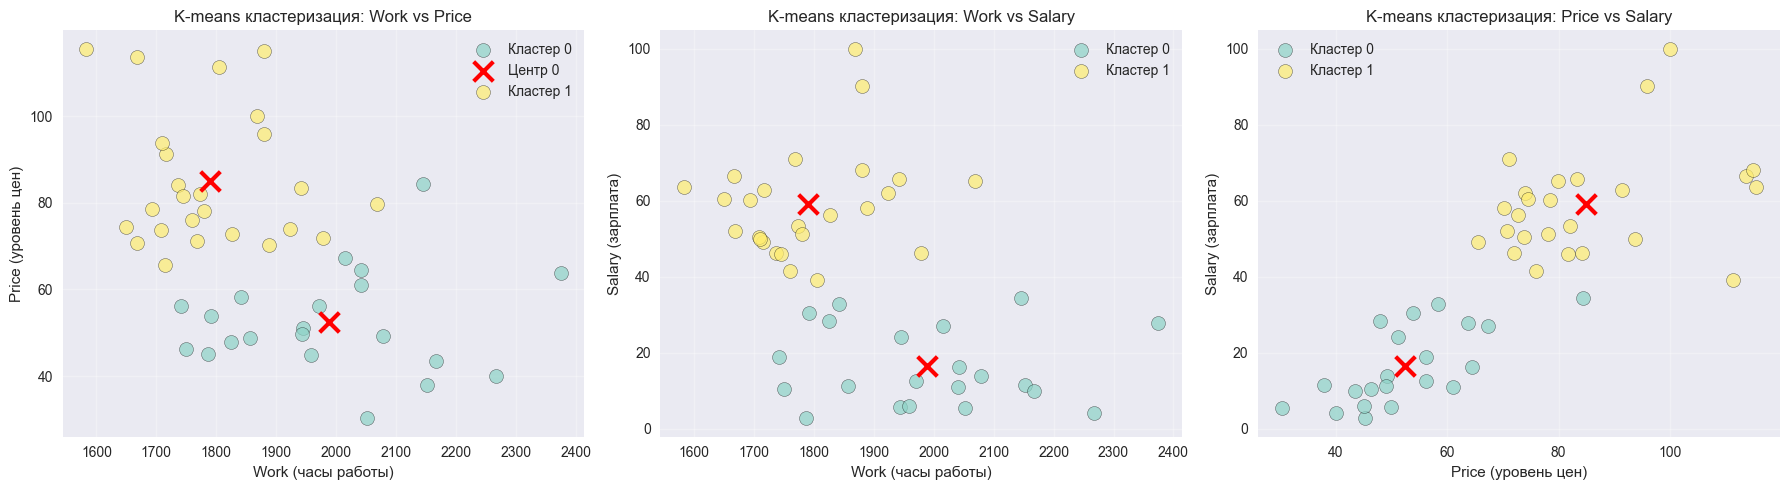

In [21]:
# Визуализация результатов K-means
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter_colors = plt.cm.Set3(np.linspace(0, 1, n_clusters_kmeans))

# Work vs Price
for cluster in range(n_clusters_kmeans):
    mask = labels_kmeans == cluster
    axes[0].scatter(features['Work'][mask], features['Price'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
    # Отмечаем центры кластеров
    axes[0].scatter(centers_original[cluster, 0], centers_original[cluster, 1], 
                    c='red', marker='x', s=200, linewidths=3, label=f'Центр {cluster}' if cluster == 0 else '')

axes[0].set_xlabel('Work (часы работы)')
axes[0].set_ylabel('Price (уровень цен)')
axes[0].set_title('K-means кластеризация: Work vs Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Work vs Salary
for cluster in range(n_clusters_kmeans):
    mask = labels_kmeans == cluster
    axes[1].scatter(features['Work'][mask], features['Salary'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
    axes[1].scatter(centers_original[cluster, 0], centers_original[cluster, 2], 
                    c='red', marker='x', s=200, linewidths=3)

axes[1].set_xlabel('Work (часы работы)')
axes[1].set_ylabel('Salary (зарплата)')
axes[1].set_title('K-means кластеризация: Work vs Salary')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Price vs Salary
for cluster in range(n_clusters_kmeans):
    mask = labels_kmeans == cluster
    axes[2].scatter(features['Price'][mask], features['Salary'][mask], 
                    c=[scatter_colors[cluster]], label=f'Кластер {cluster}', 
                    s=100, alpha=0.7, edgecolors='black')
    axes[2].scatter(centers_original[cluster, 1], centers_original[cluster, 2], 
                    c='red', marker='x', s=200, linewidths=3)

axes[2].set_xlabel('Price (уровень цен)')
axes[2].set_ylabel('Salary (зарплата)')
axes[2].set_title('K-means кластеризация: Price vs Salary')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# Статистика по кластерам (K-means)
print("Средние значения признаков по кластерам (K-means):")
cluster_stats_kmeans = df_kmeans.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
print(cluster_stats_kmeans.round(2))

print("\nРазмеры кластеров:")
print(df_kmeans.groupby('Cluster').size())


Средние значения признаков по кластерам (K-means):
            Work  Price  Salary
Cluster                        
0        1987.86  52.40   16.35
1        1789.24  84.97   59.03

Размеры кластеров:
Cluster
0    21
1    25
dtype: int64


## 5. Кластерный анализ методом DBSCAN


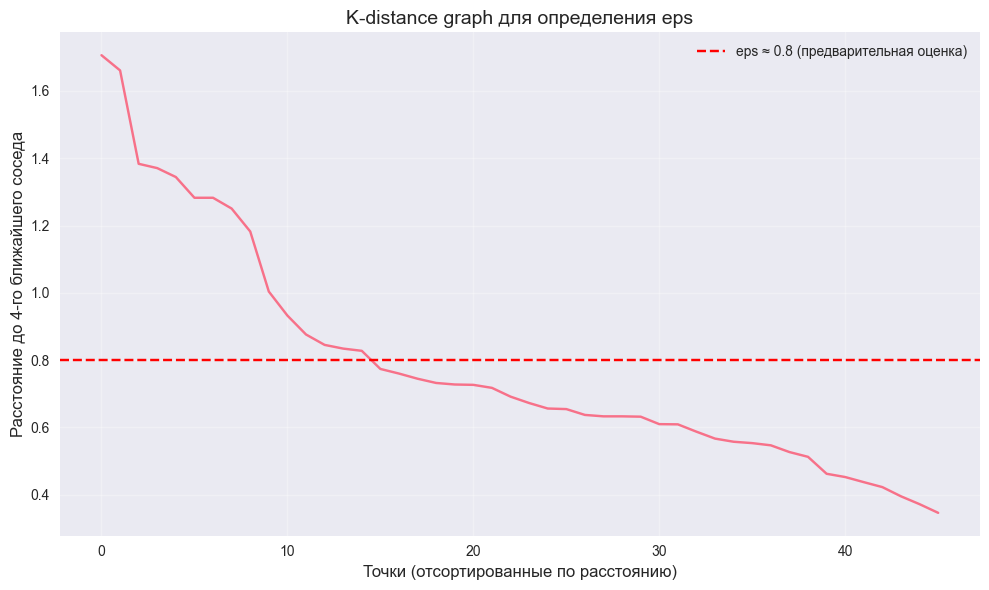

Рекомендуемый диапазон eps: [0.68210298 0.86848953]
Среднее расстояние до 4-го соседа: 0.786
Медианное расстояние до 4-го соседа: 0.682


In [23]:
# Метод k-distance graph для определения eps
from sklearn.neighbors import NearestNeighbors

# Вычисление расстояний до k-го ближайшего соседа
k = 4  # min_samples обычно выбирают как размерность данных + 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)

# Расстояния до k-го соседа
k_distances = distances[:, k-1]
k_distances_sorted = np.sort(k_distances)[::-1]

# Визуализация k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted)
plt.xlabel('Точки (отсортированные по расстоянию)', fontsize=12)
plt.ylabel(f'Расстояние до {k}-го ближайшего соседа', fontsize=12)
plt.title('K-distance graph для определения eps', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='r', linestyle='--', label='eps ≈ 0.8 (предварительная оценка)')
plt.legend()
plt.tight_layout()
plt.show()

# Анализ "локтя" на графике для определения eps
print(f"Рекомендуемый диапазон eps: {np.percentile(k_distances, [50, 75])}")
print(f"Среднее расстояние до {k}-го соседа: {np.mean(k_distances):.3f}")
print(f"Медианное расстояние до {k}-го соседа: {np.median(k_distances):.3f}")


In [24]:
# Тестирование различных комбинаций параметров eps и min_samples
eps_values = np.arange(0.5, 1.5, 0.1)
min_samples_values = [3, 4, 5]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 0:  # Только если есть кластеры
            silhouette = silhouette_score(features_scaled, labels) if n_clusters > 1 else -1
        else:
            silhouette = -1
            
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })
        
        if n_clusters > 0:
            print(f"eps={eps:.1f}, min_samples={min_samples}: {n_clusters} кластеров, {n_noise} шум, silhouette={silhouette:.3f}")

results_df = pd.DataFrame(results)


eps=0.5, min_samples=3: 3 кластеров, 23 шум, silhouette=0.008
eps=0.5, min_samples=4: 1 кластеров, 35 шум, silhouette=-1.000
eps=0.5, min_samples=5: 1 кластеров, 36 шум, silhouette=-1.000
eps=0.6, min_samples=3: 2 кластеров, 16 шум, silhouette=0.238
eps=0.6, min_samples=4: 3 кластеров, 21 шум, silhouette=0.068
eps=0.6, min_samples=5: 2 кластеров, 28 шум, silhouette=0.024
eps=0.7, min_samples=3: 2 кластеров, 11 шум, silhouette=0.333
eps=0.7, min_samples=4: 3 кластеров, 11 шум, silhouette=0.206
eps=0.7, min_samples=5: 3 кластеров, 21 шум, silhouette=0.113
eps=0.8, min_samples=3: 2 кластеров, 8 шум, silhouette=0.378
eps=0.8, min_samples=4: 2 кластеров, 8 шум, silhouette=0.378
eps=0.8, min_samples=5: 2 кластеров, 9 шум, silhouette=0.373
eps=0.9, min_samples=3: 1 кластеров, 8 шум, silhouette=-1.000
eps=0.9, min_samples=4: 1 кластеров, 8 шум, silhouette=-1.000
eps=0.9, min_samples=5: 2 кластеров, 8 шум, silhouette=0.378
eps=1.0, min_samples=3: 1 кластеров, 8 шум, silhouette=-1.000
eps=1.0, m

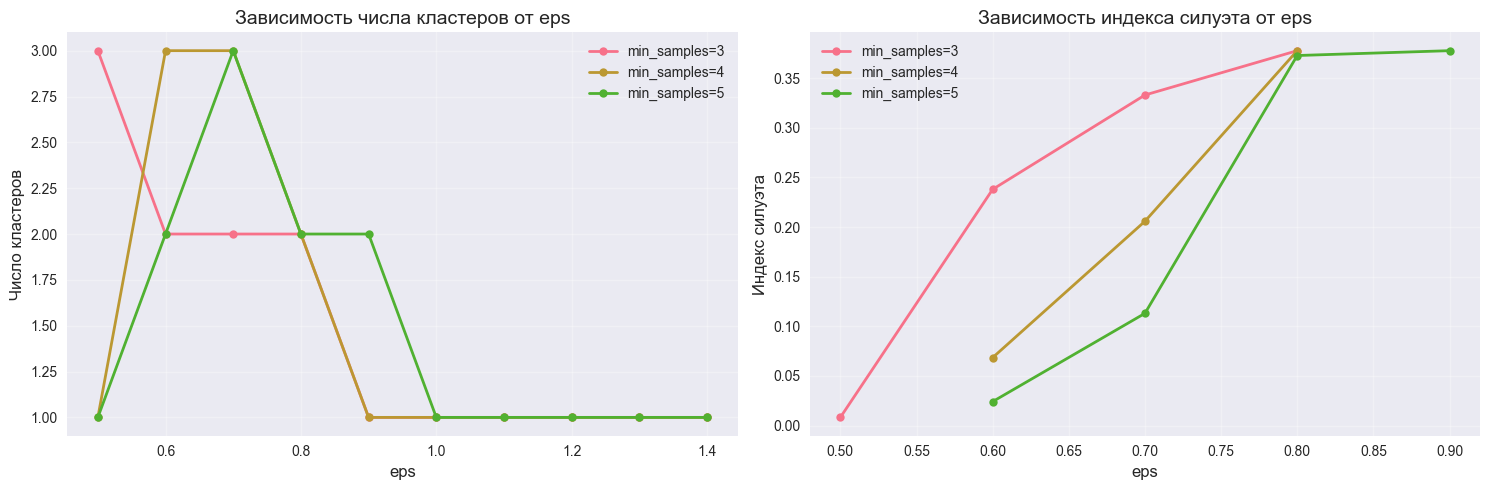

In [25]:
# Визуализация результатов подбора параметров
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for min_samples in min_samples_values:
    mask = results_df['min_samples'] == min_samples
    subset = results_df[mask]
    axes[0].plot(subset['eps'], subset['n_clusters'], 
                 marker='o', label=f'min_samples={min_samples}', linewidth=2, markersize=6)
axes[0].set_xlabel('eps', fontsize=12)
axes[0].set_ylabel('Число кластеров', fontsize=12)
axes[0].set_title('Зависимость числа кластеров от eps', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for min_samples in min_samples_values:
    mask = results_df['min_samples'] == min_samples
    subset = results_df[mask]
    valid_sil = subset[subset['silhouette'] > -1]
    if len(valid_sil) > 0:
        axes[1].plot(valid_sil['eps'], valid_sil['silhouette'], 
                     marker='o', label=f'min_samples={min_samples}', linewidth=2, markersize=6)
axes[1].set_xlabel('eps', fontsize=12)
axes[1].set_ylabel('Индекс силуэта', fontsize=12)
axes[1].set_title('Зависимость индекса силуэта от eps', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Выбор оптимальных параметров (баланс между числом кластеров и качеством)
# Исключаем результаты без кластеров и с большим количеством шума
valid_results = results_df[(results_df['n_clusters'] > 0) & 
                            (results_df['n_clusters'] < 10) &
                            (results_df['silhouette'] > -1)]

if len(valid_results) > 0:
    # Выбираем параметры с максимальным индексом силуэта
    best_result = valid_results.loc[valid_results['silhouette'].idxmax()]
    
    optimal_eps = best_result['eps']
    optimal_min_samples = int(best_result['min_samples'])
    
    print(f"Оптимальные параметры DBSCAN:")
    print(f"  eps = {optimal_eps}")
    print(f"  min_samples = {optimal_min_samples}")
    print(f"  Ожидаемое число кластеров: {int(best_result['n_clusters'])}")
    print(f"  Ожидаемое число шумовых точек: {int(best_result['n_noise'])}")
    print(f"  Индекс силуэта: {best_result['silhouette']:.3f}")
else:
    # Если не удалось найти оптимальные параметры, используем значения по умолчанию
    optimal_eps = 0.8
    optimal_min_samples = 4
    print(f"Используем параметры по умолчанию: eps={optimal_eps}, min_samples={optimal_min_samples}")


Оптимальные параметры DBSCAN:
  eps = 0.7999999999999999
  min_samples = 3
  Ожидаемое число кластеров: 2
  Ожидаемое число шумовых точек: 8
  Индекс силуэта: 0.378


In [27]:
# Выполнение DBSCAN с оптимальными параметрами
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
labels_dbscan = dbscan.fit_predict(features_scaled)

# Добавляем метки кластеров к исходным данным
df_dbscan = df_final.copy()
df_dbscan['Cluster'] = labels_dbscan

n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"Результаты DBSCAN кластеризации:")
print(f"  Число кластеров: {n_clusters_dbscan}")
print(f"  Число шумовых точек: {n_noise}")
print(f"  Параметры: eps={optimal_eps}, min_samples={optimal_min_samples}")

print(f"\nРаспределение городов по кластерам:")
print(df_dbscan['Cluster'].value_counts().sort_index())

print("\nГорода по кластерам:")
for cluster in sorted(df_dbscan['Cluster'].unique()):
    cities_in_cluster = df_dbscan[df_dbscan['Cluster'] == cluster]['City'].values
    cluster_label = 'Шум' if cluster == -1 else f'Кластер {cluster}'
    print(f"\n{cluster_label} ({len(cities_in_cluster)} городов):")
    print(f"  {', '.join(cities_in_cluster)}")


Результаты DBSCAN кластеризации:
  Число кластеров: 2
  Число шумовых точек: 8
  Параметры: eps=0.7999999999999999, min_samples=3

Распределение городов по кластерам:
Cluster
-1     8
 0    19
 1    19
Name: count, dtype: int64

Города по кластерам:

Шум (8 городов):
  Geneva, Helsinki, Hong_Kong, Oslo, Stockholm, Taipei, Tokyo, Zurich

Кластер 0 (19 городов):
  Amsterdam, Brussels, Chicago, Copenhagen, Dublin, Dusseldorf, Frankfurt, Houston, London, Los_Angeles, Luxembourg, Madrid, Milan, Montreal, New_York, Paris, Sydney, Toronto, Vienna

Кластер 1 (19 городов):
  Athens, Bogota, Bombay, Buenos_Aires, Caracas, Johannesburg, Kuala_Lumpur, Lagos, Lisbon, Manila, Mexico_City, Nairobi, Nicosia, Panama, Rio_de_Janeiro, San_Paulo, Seoul, Singpore, Tel_Aviv


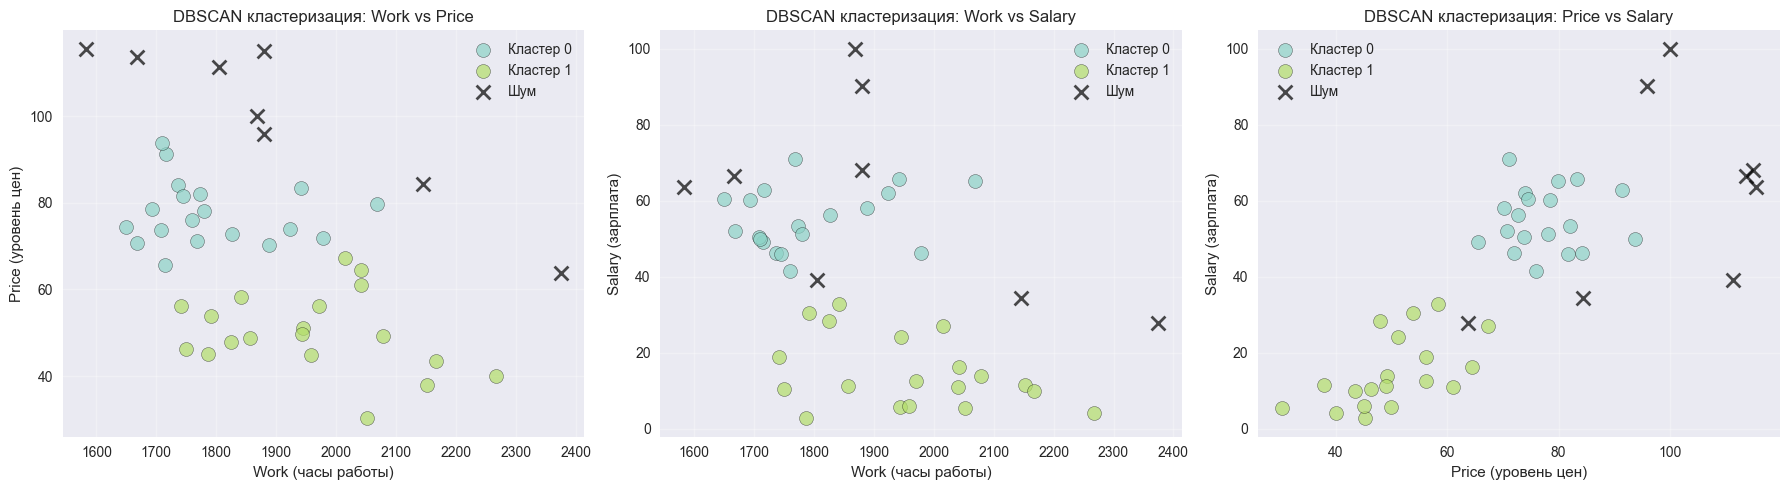

In [28]:
# Визуализация результатов DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Определяем цвета для кластеров
unique_labels = set(labels_dbscan)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Work vs Price
for label in unique_labels:
    mask = labels_dbscan == label
    if label == -1:
        axes[0].scatter(features['Work'][mask], features['Price'][mask], 
                       c='black', marker='x', s=100, alpha=0.7, 
                       label='Шум', linewidths=2)
    else:
        axes[0].scatter(features['Work'][mask], features['Price'][mask], 
                       c=[color_map[label]], label=f'Кластер {label}', 
                       s=100, alpha=0.7, edgecolors='black')
axes[0].set_xlabel('Work (часы работы)')
axes[0].set_ylabel('Price (уровень цен)')
axes[0].set_title('DBSCAN кластеризация: Work vs Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Work vs Salary
for label in unique_labels:
    mask = labels_dbscan == label
    if label == -1:
        axes[1].scatter(features['Work'][mask], features['Salary'][mask], 
                       c='black', marker='x', s=100, alpha=0.7, 
                       label='Шум', linewidths=2)
    else:
        axes[1].scatter(features['Work'][mask], features['Salary'][mask], 
                       c=[color_map[label]], label=f'Кластер {label}', 
                       s=100, alpha=0.7, edgecolors='black')
axes[1].set_xlabel('Work (часы работы)')
axes[1].set_ylabel('Salary (зарплата)')
axes[1].set_title('DBSCAN кластеризация: Work vs Salary')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Price vs Salary
for label in unique_labels:
    mask = labels_dbscan == label
    if label == -1:
        axes[2].scatter(features['Price'][mask], features['Salary'][mask], 
                       c='black', marker='x', s=100, alpha=0.7, 
                       label='Шум', linewidths=2)
    else:
        axes[2].scatter(features['Price'][mask], features['Salary'][mask], 
                       c=[color_map[label]], label=f'Кластер {label}', 
                       s=100, alpha=0.7, edgecolors='black')
axes[2].set_xlabel('Price (уровень цен)')
axes[2].set_ylabel('Salary (зарплата)')
axes[2].set_title('DBSCAN кластеризация: Price vs Salary')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [29]:
# Статистика по кластерам DBSCAN (исключая шум)
no_noise = df_dbscan[df_dbscan['Cluster'] != -1]
if len(no_noise) > 0:
    print("Средние значения признаков по кластерам (DBSCAN, без шума):")
    cluster_stats_dbscan = no_noise.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
    print(cluster_stats_dbscan.round(2))
    
    print("\nРазмеры кластеров (без шума):")
    print(no_noise.groupby('Cluster').size())

if n_noise > 0:
    print("\nСтатистика по шумовым точкам:")
    noise_stats = df_dbscan[df_dbscan['Cluster'] == -1][['Work', 'Price', 'Salary']].mean()
    print(noise_stats.round(2))


Средние значения признаков по кластерам (DBSCAN, без шума):
            Work  Price  Salary
Cluster                        
0        1792.00  77.53   55.16
1        1959.21  50.12   14.79

Размеры кластеров (без шума):
Cluster
0    19
1    19
dtype: int64

Статистика по шумовым точкам:
Work      1900.38
Price       99.93
Salary      61.26
dtype: float64


## 6. Сравнительный анализ методов и интерпретация


In [30]:
# Сравнение метрик качества кластеризации
print("Сравнение метрик качества кластеризации:")
print("-" * 60)

# Иерархический метод
sil_hier = silhouette_score(features_scaled, labels_hierarchical)
db_hier = davies_bouldin_score(features_scaled, labels_hierarchical)
print(f"Иерархический метод (n={n_clusters_hierarchical}):")
print(f"  Индекс силуэта: {sil_hier:.3f}")
print(f"  Индекс Дэвиса-Боулдина: {db_hier:.3f}")

# K-means
sil_kmeans = silhouette_score(features_scaled, labels_kmeans)
db_kmeans = davies_bouldin_score(features_scaled, labels_kmeans)
print(f"\nK-means (n={n_clusters_kmeans}):")
print(f"  Индекс силуэта: {sil_kmeans:.3f}")
print(f"  Индекс Дэвиса-Боулдина: {db_kmeans:.3f}")

# DBSCAN
if n_clusters_dbscan > 1:
    sil_dbscan = silhouette_score(features_scaled, labels_dbscan)
    db_dbscan = davies_bouldin_score(features_scaled, labels_dbscan)
    print(f"\nDBSCAN (n={n_clusters_dbscan}, шум: {n_noise}):")
    print(f"  Индекс силуэта: {sil_dbscan:.3f}")
    print(f"  Индекс Дэвиса-Боулдина: {db_dbscan:.3f}")
else:
    print(f"\nDBSCAN: недостаточно кластеров для оценки метрик")


Сравнение метрик качества кластеризации:
------------------------------------------------------------
Иерархический метод (n=2):
  Индекс силуэта: 0.470
  Индекс Дэвиса-Боулдина: 0.808

K-means (n=2):
  Индекс силуэта: 0.470
  Индекс Дэвиса-Боулдина: 0.808

DBSCAN (n=2, шум: 8):
  Индекс силуэта: 0.378
  Индекс Дэвиса-Боулдина: 1.587


In [31]:
# Создание сравнительной таблицы распределения городов
comparison_df = pd.DataFrame({
    'City': city_names,
    'Hierarchical': labels_hierarchical,
    'K-means': labels_kmeans,
    'DBSCAN': labels_dbscan
})

print("Сравнительная таблица меток кластеров:")
print(comparison_df.head(10))
print("\n...")
print(comparison_df.tail(10))

# Сохранение в CSV для детального анализа
comparison_df.to_csv('clustering_comparison.csv', index=False, encoding='utf-8')
print("\nТаблица сохранена в файл 'clustering_comparison.csv'")


Сравнительная таблица меток кластеров:
           City  Hierarchical  K-means  DBSCAN
0     Amsterdam             1        1       0
1        Athens             0        0       1
2        Bogota             0        0       1
3        Bombay             0        0       1
4      Brussels             1        1       0
5  Buenos_Aires             0        0       1
6       Caracas             0        0       1
7       Chicago             1        1       0
8    Copenhagen             1        1       0
9        Dublin             1        1       0

...
         City  Hierarchical  K-means  DBSCAN
36      Seoul             0        0       1
37   Singpore             0        0       1
38  Stockholm             1        1      -1
39     Sydney             1        1       0
40     Taipei             0        0      -1
41   Tel_Aviv             0        0       1
42      Tokyo             1        1      -1
43    Toronto             1        1       0
44     Vienna             1       

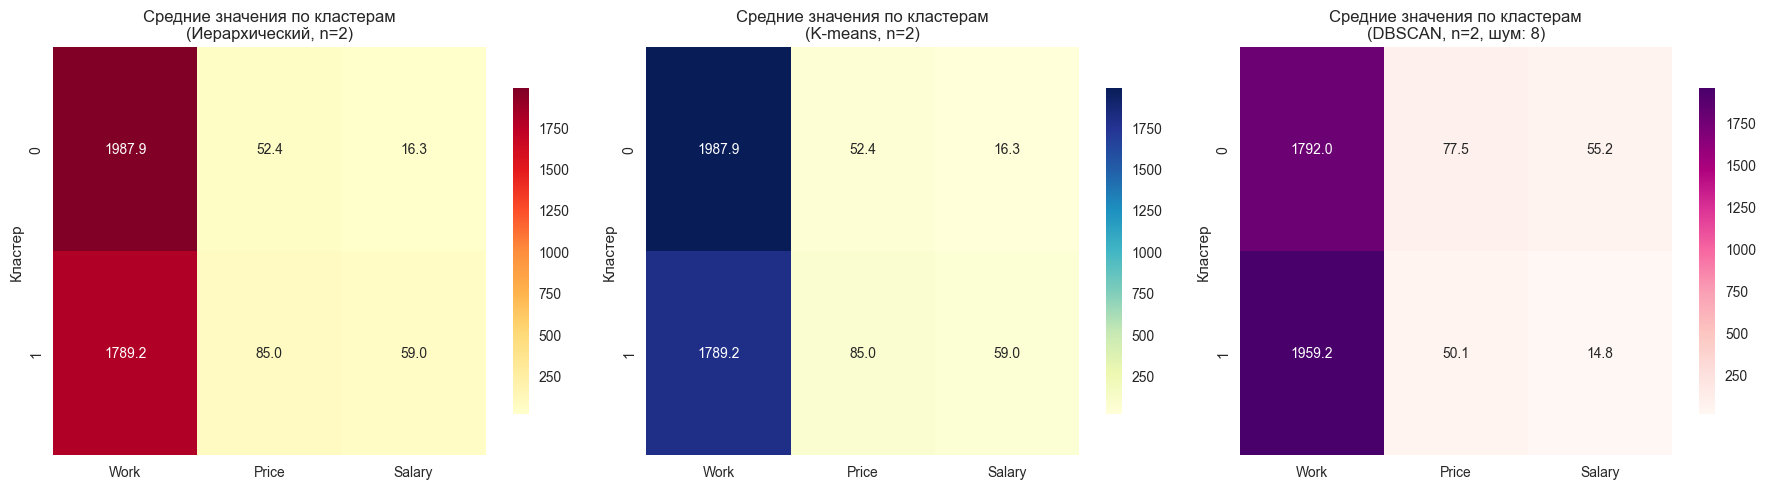

In [32]:
# Тепловые карты средних значений признаков по кластерам для каждого метода
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Иерархический метод
cluster_stats_hier = df_hierarchical.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
sns.heatmap(cluster_stats_hier, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'Средние значения по кластерам\n(Иерархический, n={n_clusters_hierarchical})', fontsize=12)
axes[0].set_ylabel('Кластер')

# K-means
cluster_stats_km = df_kmeans.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
sns.heatmap(cluster_stats_km, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'Средние значения по кластерам\n(K-means, n={n_clusters_kmeans})', fontsize=12)
axes[1].set_ylabel('Кластер')

# DBSCAN (без шума)
if n_clusters_dbscan > 0:
    no_noise = df_dbscan[df_dbscan['Cluster'] != -1]
    cluster_stats_db = no_noise.groupby('Cluster')[['Work', 'Price', 'Salary']].mean()
    sns.heatmap(cluster_stats_db, annot=True, fmt='.1f', cmap='RdPu', ax=axes[2], cbar_kws={"shrink": 0.8})
    axes[2].set_title(f'Средние значения по кластерам\n(DBSCAN, n={n_clusters_dbscan}, шум: {n_noise})', fontsize=12)
    axes[2].set_ylabel('Кластер')
else:
    axes[2].text(0.5, 0.5, 'Нет кластеров\n(все точки - шум)', 
                 ha='center', va='center', fontsize=12, transform=axes[2].transAxes)
    axes[2].set_title('DBSCAN', fontsize=12)

plt.tight_layout()
plt.show()


## 7. Интерпретация кластеров и выводы


In [33]:
# Детальный анализ кластеров K-means (как основного метода)
print("=" * 80)
print("ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ (K-means)")
print("=" * 80)

for cluster in sorted(df_kmeans['Cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster]
    cities = cluster_data['City'].values
    
    print(f"\n{'='*80}")
    print(f"КЛАСТЕР {cluster} ({len(cities)} городов)")
    print(f"{'='*80}")
    print(f"Города: {', '.join(cities)}")
    print(f"\nСредние значения признаков:")
    avg_values = cluster_data[['Work', 'Price', 'Salary']].mean()
    print(f"  Work (часы работы): {avg_values['Work']:.1f}")
    print(f"  Price (уровень цен): {avg_values['Price']:.1f}")
    print(f"  Salary (зарплата): {avg_values['Salary']:.1f}")
    
    # Интерпретация
    print(f"\nХарактеристики кластера:")
    if avg_values['Salary'] > 60:
        income_level = "Высокодоходные"
    elif avg_values['Salary'] > 30:
        income_level = "Среднедоходные"
    else:
        income_level = "Низкодоходные"
    
    if avg_values['Price'] > 80:
        price_level = "высокий уровень цен"
    elif avg_values['Price'] > 50:
        price_level = "средний уровень цен"
    else:
        price_level = "низкий уровень цен"
    
    if avg_values['Work'] > 2000:
        work_level = "высокая продолжительность работы"
    elif avg_values['Work'] > 1800:
        work_level = "средняя продолжительность работы"
    else:
        work_level = "низкая продолжительность работы"
    
    print(f"  - {income_level} города")
    print(f"  - {price_level}")
    print(f"  - {work_level}")

print(f"\n{'='*80}")
print("ОБОСНОВАНИЕ ВЫБОРА ЧИСЛА КЛАСТЕРОВ")
print(f"{'='*80}")
print(f"\nИерархический метод: {n_clusters_hierarchical} кластеров")
print(f"  - Выбрано на основе максимума индекса силуэта")
print(f"\nK-means: {n_clusters_kmeans} кластеров")
print(f"  - Выбрано на основе максимума индекса силуэта ({sil_kmeans:.3f})")
print(f"  - Индекс Дэвиса-Боулдина: {db_kmeans:.3f}")
print(f"\nDBSCAN: {n_clusters_dbscan} кластеров")
print(f"  - Определено автоматически алгоритмом")
print(f"  - Параметры: eps={optimal_eps}, min_samples={optimal_min_samples}")
if n_noise > 0:
    print(f"  - Обнаружено {n_noise} шумовых точек (аномалии)")


ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ (K-means)

КЛАСТЕР 0 (21 городов)
Города: Athens, Bogota, Bombay, Buenos_Aires, Caracas, Hong_Kong, Johannesburg, Kuala_Lumpur, Lagos, Lisbon, Manila, Mexico_City, Nairobi, Nicosia, Panama, Rio_de_Janeiro, San_Paulo, Seoul, Singpore, Taipei, Tel_Aviv

Средние значения признаков:
  Work (часы работы): 1987.9
  Price (уровень цен): 52.4
  Salary (зарплата): 16.3

Характеристики кластера:
  - Низкодоходные города
  - средний уровень цен
  - средняя продолжительность работы

КЛАСТЕР 1 (25 городов)
Города: Amsterdam, Brussels, Chicago, Copenhagen, Dublin, Dusseldorf, Frankfurt, Geneva, Helsinki, Houston, London, Los_Angeles, Luxembourg, Madrid, Milan, Montreal, New_York, Oslo, Paris, Stockholm, Sydney, Tokyo, Toronto, Vienna, Zurich

Средние значения признаков:
  Work (часы работы): 1789.2
  Price (уровень цен): 85.0
  Salary (зарплата): 59.0

Характеристики кластера:
  - Среднедоходные города
  - высокий уровень цен
  - низкая продолжительность работы

ОБОСНОВАНИЕ В

## 8. Заключение

### Выводы по выполненной работе:

1. **Иерархический кластерный анализ** позволил выявить естественную структуру данных с оптимальным числом кластеров, определенным на основе индекса силуэта.

2. **K-means кластеризация** показала хорошие результаты с четким разделением городов на группы по экономическим характеристикам.

3. **DBSCAN** выявил плотные области в данных и позволил обнаружить аномальные точки (шум), которые могут требовать особого внимания.

4. Все три метода подтвердили наличие различий в экономических характеристиках городов и позволили классифицировать их на группы:
   - Высокодоходные развитые города с высоким уровнем цен
   - Среднедоходные города
   - Низкодоходные города с низким уровнем цен

5. Выбранное число кластеров обосновано метриками качества (индекс силуэта, индекс Дэвиса-Боулдина) и визуальным анализом дендрограмм.
